In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from sklearn.model_selection import train_test_split
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS

In [2]:
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)

In [3]:
# Load the data

Auto = load_data('Auto')
Auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
388,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
389,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
390,28.0,4,120.0,79,2625,18.6,82,1,ford ranger


In [4]:
# We can also impute the missing values of "horsepower" as we did previously

Auto['horsepower'].replace('?','104',inplace=True)
Auto['horsepower'] = pd.to_numeric(Auto['horsepower'])

In [5]:
# We will use the numeric variables in the data to predict mpg

X = Auto[['cylinders','displacement','horsepower','weight','acceleration','year','origin']]
y = Auto['mpg']

In [6]:
# Create train and test split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=314,
                                                    test_size=0.25,
                                                    shuffle=True) 
Train = pd.merge_ordered(X_train,y_train,left_on=X_train.index,right_on=y_train.index).drop(columns=['key_0'])
Test = pd.merge_ordered(X_test,y_test,left_on=X_test.index,right_on=y_test.index).drop(columns=['key_0'])

X_train

,cylinders,displacement,horsepower,weight,acceleration,year,origin
28,8,304.0,193,4732,18.5,70,1
131,6,250.0,100,3781,17.0,74,1
58,4,97.0,54,2254,23.5,72,2
215,4,111.0,80,2155,14.8,77,1
255,6,232.0,90,3210,17.2,78,1
...,...,...,...,...,...,...,...
42,8,400.0,170,4746,12.0,71,1
342,4,97.0,67,2065,17.8,81,3
201,4,97.0,71,1825,12.2,76,2
109,4,108.0,94,2379,16.5,73,3


## Gradient Boosting

In [34]:
# Build the model
# Documentation: https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

gbm_auto = GBR(learning_rate=0.001,
               n_estimators=5000,
               max_depth=5,
               random_state=314)
gbm_auto.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.001, max_depth=5, n_estimators=5000,
                          random_state=314)

In [35]:
# Calculate MSE on test set

# Get predictions on test
y_hat_gbm = gbm_auto.predict(X_test)

# Calculate MSE
mse_gbm = np.mean((y_test - y_hat_gbm)**2)
print('test mse: ',mse_gbm)

test mse:  4.767608358097728


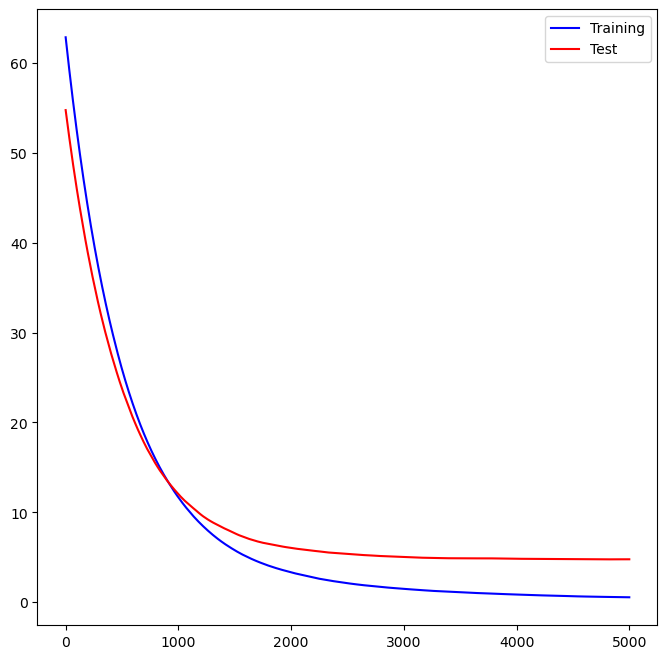

In [36]:
# We can actually plot the "progress" of a GBM

test_error = np.zeros_like(gbm_auto.train_score_)
for idx, y_ in enumerate(gbm_auto.staged_predict(X_test)):
   test_error[idx] = np.mean((y_test - y_)**2)

plot_idx = np.arange(gbm_auto.train_score_.shape[0])
ax = subplots(figsize=(8,8))[1]
ax.plot(plot_idx,
        gbm_auto.train_score_,
        'b',
        label='Training')
ax.plot(plot_idx,
        test_error,
        'r',
        label='Test')
ax.legend();

In [37]:
# Feature importance list
feature_names = list(X_train.columns)
feature_imp = pd.DataFrame(
    {'importance':gbm_auto.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
displacement,0.624364
year,0.127355
horsepower,0.115051
weight,0.094027
acceleration,0.030221
origin,0.005411
cylinders,0.003570


In [15]:
# Ask ChatGPT to create a function to make lift charts

import matplotlib.pyplot as plt

def plot_regression_lift_chart(y_true, y_preds, n_bins=10):
    """
    Plots a lift chart for a regression model.

    Parameters:
    - y_true: Array-like of true continuous values.
    - y_preds: Array-like of predicted values.
    - n_bins: Number of bins to use for the lift chart.
    """
    # Create a DataFrame with true values and predicted values
    data = pd.DataFrame({'y_true': y_true, 'y_preds': y_preds})
    
    # Sort the DataFrame by predicted values
    data = data.sort_values(by='y_preds', ascending=False)

    # Create bins based on predicted values
    data['bin'] = pd.qcut(data['y_preds'], n_bins, labels=False)

    # Calculate lift
    lift_data = data.groupby('bin').agg(
        total_count=('y_true', 'count'),
        actual_mean=('y_true', 'mean'),
        predicted_mean=('y_preds', 'mean')
    ).reset_index()

    # Calculate expected mean (mean of actual values)
    expected_mean = data['y_true'].mean()
    
    # Calculate lift
    lift_data['lift'] = lift_data['actual_mean'] / expected_mean

    # Plot the lift chart
    plt.figure(figsize=(10, 6))
    plt.plot(lift_data['bin'], lift_data['lift'], marker='o', label='Lift')
    plt.axhline(y=1, color='r', linestyle='--', label='Random Guessing Lift (1)')
    plt.title('Lift Chart for Regression Model')
    plt.xlabel('Bins')
    plt.ylabel('Lift')
    plt.xticks(lift_data['bin'])
    plt.legend()
    plt.grid()
    plt.show()

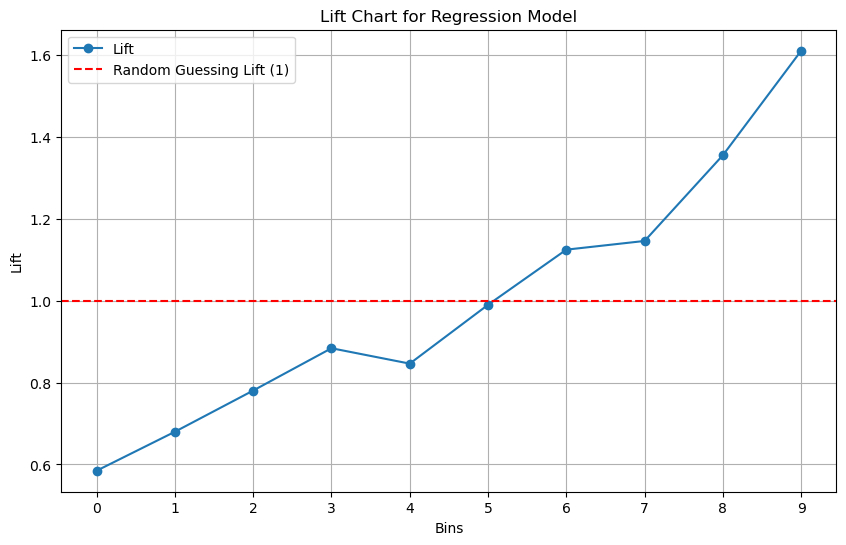

In [16]:
plot_regression_lift_chart(y_test, y_hat_gbm, n_bins=10)